In [1]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader,random_split,SubsetRandomSampler, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchsummary import summary
import tqdm



In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/challenge
!pwd


ModuleNotFoundError: No module named 'google.colab'

In [3]:
args = {"TRAIN_LABEL_CSV" : './train_labels.csv',
        "TRAIN_PATH" : "../input/invasivespecies/train",
        "TEST_PATH" : "../input/invasivespecies/test",
        "RESIZE" : 224,#(224,224),
        "LEARNING_RATE" : 0.001,
        "WEIGHT_DECAY" : 0.003,
        "BATCH_SIZE" : 32,
        "FEATURE_EXTRACTING" : True,
        "NUM_EPOCHS" : 50,
        "MEAN" : (0.485, 0.456, 0.406),
        "STD" : (0.229, 0.224, 0.225),
        "BETA" : 1.0,
        "MODEL" : "efficient",
        "MODEL_PATH" : ".",
        "NUM_FOLDS" : 5,
        "DEVICE" : torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')}


In [4]:
#load npy files
train_dataset = np.load('trainset.npy')
train_label = np.load('trainlabel.npy')
test_dataset = np.load('testset.npy')

print(train_dataset.shape)


(50000, 32, 32, 3)


In [5]:
train_data=[]
for idx, data in enumerate(train_dataset):
    train_data.append([data,train_label[idx]])

In [6]:
# Function: Split Data
def shuffle_train_valid_split(X, test_size=0.1, shuffle=True, random_state=1004):
    test_num = int(len(X) * test_size)
    train_num = len(X) - test_num
    
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(X)
        X_train = X[:train_num]
        X_valid = X[train_num:]
    else:
        X_train = X[:train_num]
        X_valid = X[train_num:]
        
    return X_train, X_valid

In [7]:
train_data, valid_data = shuffle_train_valid_split(train_data)

print(len(train_data))

45000


In [25]:
#custom dataset 
class CustomDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data = [data[0] for data in input]
        self.y_data = [data[1] for data in input]
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        if self.transform:
            x = self.transform(x)

        return x, y
        

In [26]:
#custom dataset 
class testDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data =input
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        if self.transform:
            x = self.transform(x)

        return x
        

In [27]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize(mean=args["MEAN"], std=args["STD"])
    #transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=args["MEAN"], std=args["STD"])
    #transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
])


In [29]:
traindata = CustomDataset(train_data, transform=transform_train)
validdata = CustomDataset(valid_data, transform=transform_test)
testdata = testDataset(test_dataset, transform=transform_test)


#data loader
train_loader = DataLoader(traindata, batch_size=args["BATCH_SIZE"], shuffle=True)
valid_loader = DataLoader(validdata, batch_size=args["BATCH_SIZE"], shuffle=True)
test_loader = DataLoader(testdata, batch_size=args["BATCH_SIZE"], shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


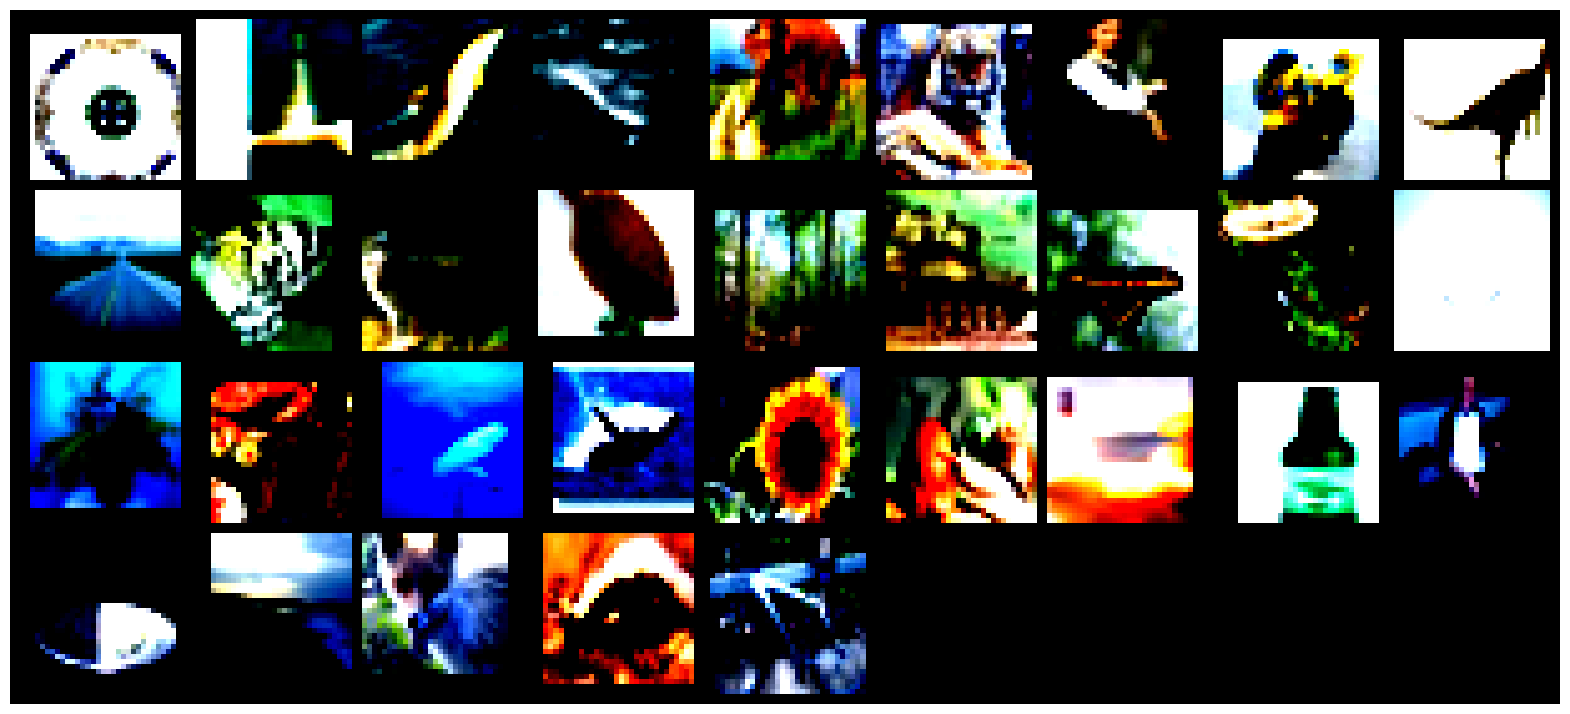

In [30]:
#print sample image with label from train_loader


for i, (images, labels) in enumerate(train_loader):
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=9).permute((1, 2, 0)))
    break


In [31]:
def rand_bbox(size, lam): # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int(W * cut_rat)  # 패치의 너비
    cut_h = np.int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [32]:
class Mish(nn.Module):


    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [33]:
import torch
import torch.nn as nn
class SEUnit(nn.Sequential):
    """ Squeeze and Excitation def.
    (hint 1): change nn.Identity() to appropriate class name
    """
    def __init__(self, ch, r=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, int(ch/r), bias=False),
            nn.Mish(),
            nn.Linear(int(ch / r), ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DepthSeperabelConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super().__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                input_channels,
                input_channels,
                kernel_size,
                groups=input_channels,
                **kwargs),
            nn.BatchNorm2d(input_channels),
            nn.Mish()
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.Mish()
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x


class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):

        super().__init__()
        self.conv = nn.Conv2d(
            input_channels, output_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.Mish()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class MobileNet(nn.Module):

    def __init__(self, width_multiplier=1, class_num=100):
       super().__init__()

       alpha = width_multiplier
       self.stem = nn.Sequential(
           BasicConv2d(3, int(32 * alpha), 3, padding=1, bias=False),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(32 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv1 = nn.Sequential(
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(32 * alpha),
               3,
               stride=1,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(32 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv2 = nn.Sequential(
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(32 * alpha),
               3,
               stride=1,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv3 = nn.Sequential(
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(64 * alpha),
               3,
               stride=1,
               padding=1,
               bias=False
           ),

           DepthSeperabelConv2d(
               int(64 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(128 * alpha),
               3,
               padding=1,
               bias=False
           ),SEUnit(128)
       )

       #downsample
       self.conv4 = nn.Sequential(
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(128 * alpha),
               3,
               stride=1,
               padding=1,
               bias=False
           ),SEUnit(128),
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(128 * alpha),
               3,
               padding=1,
               bias=False
           ),SEUnit(128)
       )
        
       self.fc = nn.Linear(int(128 * alpha), class_num)
       self.avg = nn.AdaptiveAvgPool2d(1)
       self.pool = nn.MaxPool2d(2, 2)
       self.dropout = nn.Dropout(0.2)
      #  weight initialization with he_normal
       for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        

    def forward(self, x):
        x = self.stem(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.pool(x)
        x = self.conv4(x)
        #x = self.pool(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


def mobilenet(alpha=1, class_num=100):
    return MobileNet(alpha, class_num)

In [34]:
for batch, (X,y)in enumerate(train_loader):
    print(batch)
    print(X.shape)
    print(y.shape)
    break

0
torch.Size([32, 3, 32, 32])
torch.Size([32])


In [35]:
device =  "cuda" if torch.cuda.is_available() else "cpu"

In [37]:

print("Using {} device".format(device))

model = mobilenet().to(device)
#model.load_state_dict(torch.load('./fixmodel3.pt'))


optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,total_steps=args["NUM_EPOCHS"],steps_per_epoch=len(train_loader), epochs=args["NUM_EPOCHS"])
lrs = []
train_acc=[]
val_acc =[]

Using cpu device


In [38]:
X,y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)

lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
rand_index = torch.randperm(X.size()[0]).to(device) # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.
shuffled_y = y[rand_index] # 타겟 레이블을 랜덤하게 셔플합니다.

print(lam)
print(rand_index)


0.3681160265708517
tensor([15, 19,  9, 21, 16, 22, 27,  2, 31, 10, 30, 23,  4, 29,  5,  3,  1, 14,
         0, 25, 26, 20,  6, 28, 11, 13, 17,  7, 12, 18, 24,  8])


In [39]:
bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
X[:,:,bbx1:bbx2, bby1:bby2] = X[rand_index,:,bbx1:bbx2, bby1:bby2]

/var/folders/28/mxz_d7ln5bs9tv85nsl3xf040000gn/T/ipykernel_33565/3290787242.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)  # 패치의 너비
/var/folders/28/mxz_d7ln5bs9tv85nsl3xf040000gn/T/ipykernel_33565/3290787242.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

In [40]:
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2]))
print(lam)

0.671875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


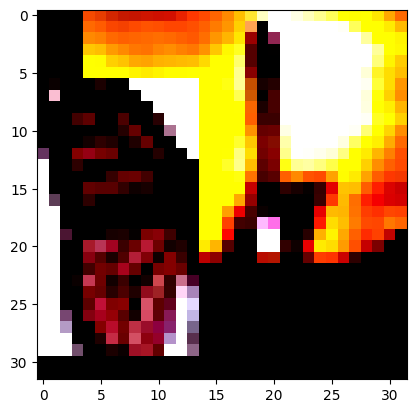

In [41]:
plt.imshow(X[0].permute(1, 2, 0).cpu())

/var/folders/28/mxz_d7ln5bs9tv85nsl3xf040000gn/T/ipykernel_33565/3290787242.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)  # 패치의 너비
/var/folders/28/mxz_d7ln5bs9tv85nsl3xf040000gn/T/ipykernel_33565/3290787242.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

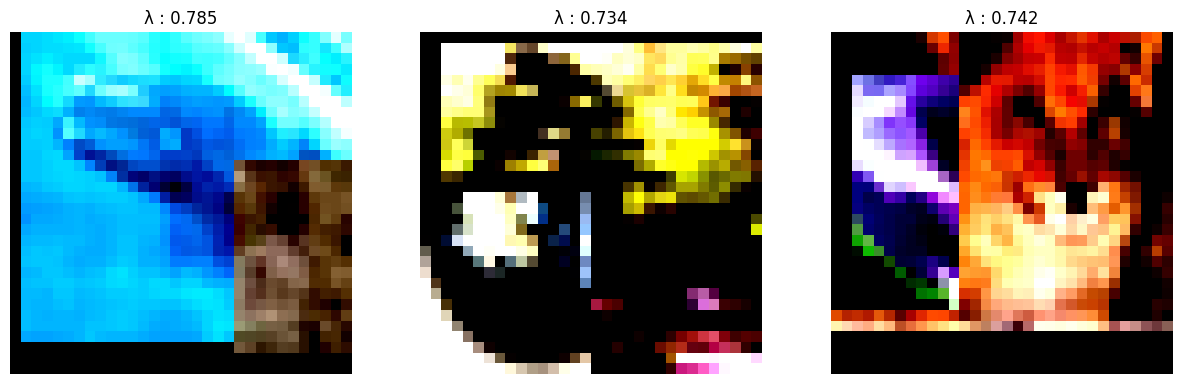

In [42]:
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)
    
    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0) 
        rand_index = torch.randperm(inputs.size()[0])
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

In [43]:
def validation(model, valid_loader, criterion):

    accuracy = 0
    valid_loss = 0
    y_score = []

    for i, (X, y) in enumerate(valid_loader):
        if torch.cuda.is_available():
            X = X.to('cuda')
            y = y.to('cuda')

        outputs = model(X)
        loss = criterion(outputs, y)
        valid_loss += loss.item()
        outputs_ = torch.argmax(outputs, dim=1)
        
        accuracy += (outputs_ == y).float().sum()
        
        # For roc_auc_score
        outputs = F.softmax(outputs, dim=-1)
        y_score.append(outputs.detach().cpu().numpy())
    
    y_score = np.array([i for sub in y_score for i in sub])

    return valid_loss, accuracy, y_score

In [44]:
import os
def train_model(model, train_loader, valid_loader, criterion, optimizer, args, fold_num=1):
    steps = 0
    total_step = len(train_loader)
    train_losses, validation_losses = [], []
    best_val = np.inf
    
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,total_steps=args["NUM_EPOCHS"],steps_per_epoch=len(train_loader), epochs=args["NUM_EPOCHS"])
    
    if torch.cuda.is_available():
        model = model.to(args["DEVICE"])

    for epoch in range(args['NUM_EPOCHS']):
        running_loss = 0
        for i, (X, y) in enumerate(train_loader):
            
            if torch.cuda.is_available():
                X = X.to(args["DEVICE"])
                y = y.to(args["DEVICE"])

                
            if args["BETA"] > 0 and np.random.random()>0.5: # cutmix 작동될 확률      
                lam = np.random.beta(args["BETA"], args["BETA"])
                rand_index = torch.randperm(X.size()[0]).to(args["DEVICE"])
                target_a = y
                target_b = y[rand_index]            
                bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
                X[:, :, bbx1:bbx2, bby1:bby2] = X[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2]))
                outputs = model(X)
                loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
                
            else:
                outputs = model(X)
                loss = criterion(outputs, y)                  
                
            steps += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if steps % total_step == 0:
                model.eval()
                with torch.no_grad():
                    valid_loss, accuracy, y_score = validation(model, valid_loader, criterion)

                print("Epoch: {}/{}.. ".format(epoch + 1, args['NUM_EPOCHS']) +
                      "Training Loss: {:.5f}.. ".format(running_loss / total_step) +
                      "Valid Loss: {:.5f}.. ".format(valid_loss / len(valid_loader)) +
                      "Valid Accuracy: {:.5f}.. ".format(accuracy / len(valid_loader.dataset)) )
                
                # Save Model
                if (valid_loss / len(valid_loader)) < best_val:
                    best_val = (valid_loss / len(valid_loader))
                    torch.save(model.state_dict(), f"{args['MODEL_PATH']}/{fold_num}_best_checkpoint_{str(epoch + 1).zfill(3)}epoch.tar")
                    try:
                        os.remove(f_pth)
                    except:
                        pass
                    f_pth = f"{args['MODEL_PATH']}/{fold_num}_best_checkpoint_{str(epoch + 1).zfill(3)}epoch.tar"
                
                train_losses.append(running_loss / len(train_loader))
                validation_losses.append(valid_loss / len(valid_loader))
                steps = 0
                running_loss = 0
                model.train()
                
        scheduler.step(valid_loss / len(valid_loader))

    return 


In [45]:
train_model(model, train_loader, valid_loader, criterion, optimizer, args, fold_num=1)

/var/folders/28/mxz_d7ln5bs9tv85nsl3xf040000gn/T/ipykernel_33565/3290787242.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)  # 패치의 너비
/var/folders/28/mxz_d7ln5bs9tv85nsl3xf040000gn/T/ipykernel_33565/3290787242.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              Mish-3           [-1, 32, 32, 32]               0
       BasicConv2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              Mish-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           1,056
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             Mish-10           [-1, 32, 32, 32]               0
DepthSeperabelConv2d-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]             288
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             Mish-14           [-1, 

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

In [ ]:
plt.plot(lrs)

In [ ]:
import pandas as pd
#model.load_state_dict(torch.load('cutmix.pt'))
id_list = []
pred_list = []
_id = 0
model.eval()
with torch.no_grad():
    for x in test_loader:
        preds = model(x.cuda())
        preds = preds.argmax(1)
        for pred in preds:
            id_list.append(_id)
            pred_list.append(pred.item())
            _id += 1

res = pd.DataFrame({
    'id_idx': id_list,
    'label': pred_list
}) 

res.sort_values(by='id_idx', inplace=True)

res.to_csv('./cutmix.csv', index=False) 
print("result saved")

In [ ]:
!nvidia-smi --query | fgrep 'Product Name'
